In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
work_dir = '/home/kahmadov/phd/migration'
sys.path.append(f'{work_dir}/modules')
import aperture_solver
import elastic_solution

In [2]:
with open(f'{work_dir}/results/results_fvm.pkl', 'rb') as f:
    results_fvm = pickle.load(f)

with open(f'{work_dir}/results/parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [3]:
t_fin_vals = [25, 80, 100, 120]

In [4]:
def symmetrize(x_data, y_data):
    x_sym = np.concatenate((-x_data[::-1][:-1], x_data))
    y_sym = np.concatenate((y_data[::-1][:-1], y_data))
    return x_sym, y_sym

def make_RHS(P_xt_data, t, t_fin):
    x_arr = np.linspace(0, 100, P_xt_data.shape[1])
    Nt = P_xt_data.shape[0]
    dt = t_fin / Nt
    # Compute index at time t for FVM data
    idx_t = int(t / dt) - 1
    P_x = P_xt_data[idx_t]

    def RHS(s):
        # symmetrize
        x_sym, P_sym = symmetrize(x_arr, P_x)
        # interpolate normalize by an order of magnitude
        return np.interp(s*parameters["L"], x_sym, P_sym)/1e6
    return RHS


In [5]:
E_ = parameters['E']/ (1-parameters['nu']**2)
lam = 4/np.pi * parameters['k_n'] * parameters['L'] / E_

In [6]:
sn_data = {}
p_sn_data = {}
t_sn_data = {}

for q_0, t_fin in zip(results_fvm.keys(), t_fin_vals):
    P_xt_fvm = results_fvm[q_0]['p']
    Nt_sn = 50
    dt_sn = t_fin/Nt_sn
    t_vals = np.linspace(dt_sn, t_fin, Nt_sn)
    sn_xt = []
    p_sn_xt = []
    for t in t_vals:
        RHS = make_RHS(P_xt_fvm, t, t_fin)
        x_hat, sn_hat, p_hat = elastic_solution.FIE_log_sing(lam, RHS)
        mask = x_hat>=0
        sn_xt.append(sn_hat[mask]*1e6)
        p_sn_xt.append(p_hat[mask]*1e6)
        x_sn = x_hat[mask]*parameters["L"]
        
    sn_xt = np.array(sn_xt)
    p_sn_xt = np.array(p_sn_xt)
    sn_data[q_0] = sn_xt
    p_sn_data[q_0] = p_sn_xt
    t_sn_data[q_0] = t_vals

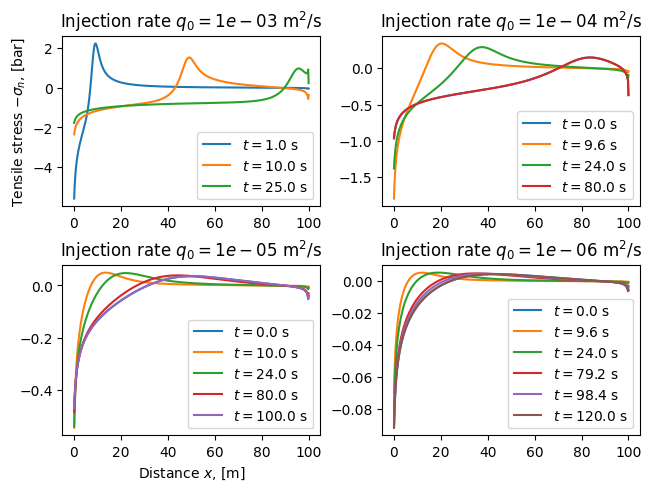

In [7]:
q_0 = 1e-3
t_fin = 25
q_0_vals = [1e-3, 1e-4, 1e-5, 1e-6]
t_vals_for_q = [[1, 10, 25],
                  [1, 10, 25, 80],
                  [1, 10, 25, 80, 100],
                  [1, 10, 25, 80, 100, 120]]
t_fin_vals = [25, 80, 100, 120]

fig,axes = plt.subplots(2, 2, constrained_layout=True)
for i, (ax, q_0, t_vals, t_fin) in enumerate(zip(axes.flatten(), q_0_vals, t_vals_for_q, t_fin_vals)):
    sn_xt = sn_data[q_0]
    Nt = sn_xt.shape[0]
    dt = t_fin / Nt
    for t in t_vals:
        idx_t = int(t / dt) - 1 
        ax.plot(x_sn, -sn_xt[idx_t]/1e5, label=fr'$t={(idx_t+1)*dt:.1f}$ s')
    ax.set_title(f'Injection rate $q_0={q_0:.0e}~\mathsf{{m^2/s}}$')
    ax.legend()

axes[0,0].set_ylabel(r"Tensile stress $-\sigma_n$, [bar]")
axes[1,0].set_xlabel(r"Distance $x$, [m]")
plt.savefig(f'{work_dir}/figures/stress-profiles.png', dpi=300)
plt.show()

In [14]:
q_0 = 1e-3
t_fin = 25
x_f_data = {}
for q_0, t_fin in zip(q_0_vals, t_fin_vals):
    sn_xt = sn_data[q_0]
    Nt = sn_xt.shape[0]
    dt = t_fin / Nt
    x_f_for_q = []
    for idx, sn_x in enumerate(sn_xt):
        t = (idx+1)*dt
        sn_max = np.max(-sn_x)
        x_f = x_sn[np.argmax(-sn_x)]
        x_f_for_q.append(x_f)
    x_f_data[q_0] = np.array(x_f_for_q)

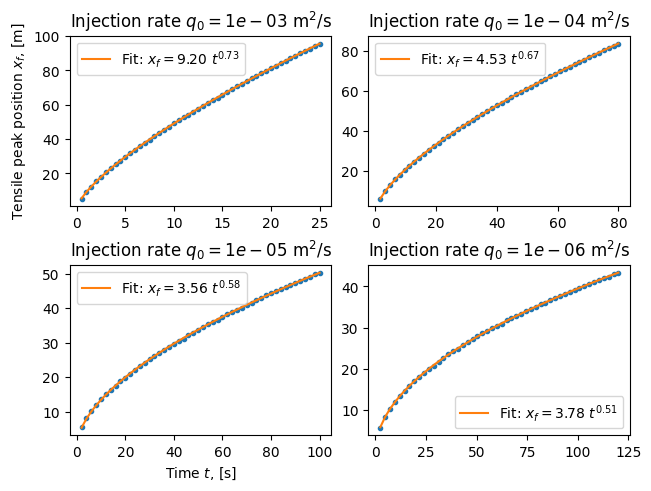

In [37]:
from scipy.optimize import curve_fit
def power_law(x, a,b):
    return a*x**b
    
fig,axes = plt.subplots(2, 2, constrained_layout=True)

for i, (ax, q_0) in enumerate(zip(axes.flatten(), q_0_vals)):

    popt, pcov = curve_fit(power_law, t_sn_data[q_0], x_f_data[q_0], p0=(1, 1))
    a_fit, b_fit = popt
    
    x_f_fit = power_law(t_sn_data[q_0], a_fit, b_fit)
    
    ax.plot(t_sn_data[q_0], x_f_data[q_0], '.')
    ax.plot(t_sn_data[q_0], x_f_fit, '-', label=fr'Fit: $x_f = {a_fit:.2f} ~ t^{{{b_fit:.2f}}}$')
    
    ax.set_title(f'Injection rate $q_0={q_0:.0e}~\mathsf{{m^2/s}}$')
    ax.legend()

axes[0,0].set_ylabel(r'Tensile peak position $x_f$, [m]')
axes[1,0].set_xlabel(r'Time $t$, [s]')
plt.savefig(f'{work_dir}/figures/stress-migration.png', dpi=300)
plt.show()

In [10]:
np.linspace(0.05, 25, 50)

array([ 0.05      ,  0.55918367,  1.06836735,  1.57755102,  2.08673469,
        2.59591837,  3.10510204,  3.61428571,  4.12346939,  4.63265306,
        5.14183673,  5.65102041,  6.16020408,  6.66938776,  7.17857143,
        7.6877551 ,  8.19693878,  8.70612245,  9.21530612,  9.7244898 ,
       10.23367347, 10.74285714, 11.25204082, 11.76122449, 12.27040816,
       12.77959184, 13.28877551, 13.79795918, 14.30714286, 14.81632653,
       15.3255102 , 15.83469388, 16.34387755, 16.85306122, 17.3622449 ,
       17.87142857, 18.38061224, 18.88979592, 19.39897959, 19.90816327,
       20.41734694, 20.92653061, 21.43571429, 21.94489796, 22.45408163,
       22.96326531, 23.47244898, 23.98163265, 24.49081633, 25.        ])